<a href="https://colab.research.google.com/github/FlexliTushar/Flow-Charts/blob/main/TrafficManagementService.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TMS - Flow Control Feature

## Strategy

In [ ]:
//Messaging_server will send bot-position of Bx as
// X -> S6 -> D7 when passing station X
GET new bot-positions;
// To resolve the occupied and allocated station requests of Bx for X and S6.
2 iterations of TMS;
//1. It will try to make request for D7 in 3rd iteration but that will be rejected and added into rejectedRequests in StationAllocationPlanService
// 2. In 4th iteration it will create request for original assigned station
CREATE station request for Bx of
type 'Assign' for D7;
if((Bx, D7, Assign) EXIST in
rejectedRequests)
{
  //1. TRIGGER - Assigned Station was not available
  //2. Allocated station here S6 which is a flow control station
  if(Allocated Station is a Flow
  Control Station?)
  {
    // The bot By which is occupying the station D7 i.e. station for which assigned request is rejected
    // (Refer checkBot motor for 'By' flow chart)
    if(Motor of ahead bot 'By' = True)
    {
      // Means bot is already moving ahead and will not create congestion
      Continue with existing logic;
    }
    else
    {
      //Refer Redirection Flow Chart
      REDIRECT Bx;
      // After redirection, the valid next station comes out to be S5
      CREATE new station request of Bx
      for S5 of type 'Assign';
      // _redirectedRequests will keep the track of all the redirected requests that have occured in this iteration in BotStationRequestService
      ADD (Bx, S5, Assign) in
      _redirectedRequests;
      Continue with existing logic;
    }
  }
  
  // if not a flow control station then cannot do anything
  else
  {
    Continue with existing logic;
  }
}
// assign station request was not rejected/coming first time
else
{
  Continue with existing logic;
}
// redirectedRequests from BotStationRequests are used to update the Rule = R and RedirectedStationId = S5 for Bx

UPDATE unresolvedBotPositions using
redirectedRequests;
// 1. It will try to update for both original assign request for D7 and redirected assign request for S5
// 2. If original is completed then redirected request is added into _nonRequiredRequests
// 3. For every request if it exists in _nonRequiredRequests then break (this will ensure that if original request is fulfilled then no need to process redirection request)
// 4. If request not completed then add it to _rejectedrequests
UPDATE the station allocation plan;
UPDATE the bot_motor;
// If it does gets D7
if(Assigned Station is given to Bx?)
{
  Continue with existing logic;
}
// If redirected assign request is resolved for S5
else
{
  if(Rule = R? and BotId in Redirected
  Station Plan is same as as Bx)
  {
    WRITE motor command with
    Code 'R' and assigned station id
    as redirected station id;
    Continue with existing logic;
  }
  else
  {
    Continue with existing logic;
  }
}

// simulation bot code
if(Bot gets Rule R?)
{
  REPLAN AND RECALCULATE path
  according to new bot_motor;
  Continue with existing logic;
}
else
{
  Continue with existing logic;
}

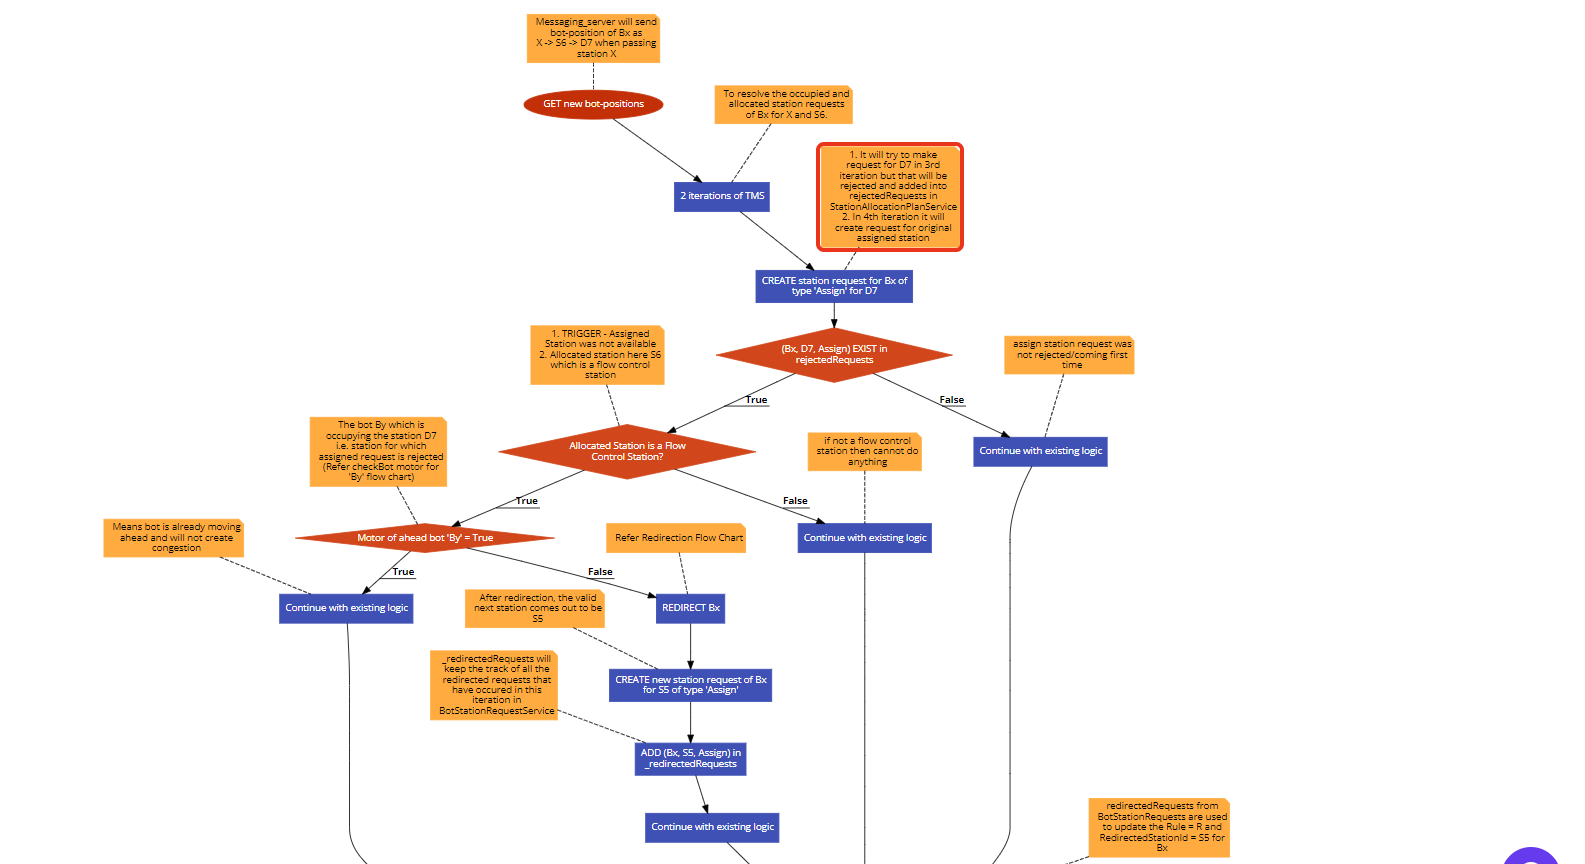

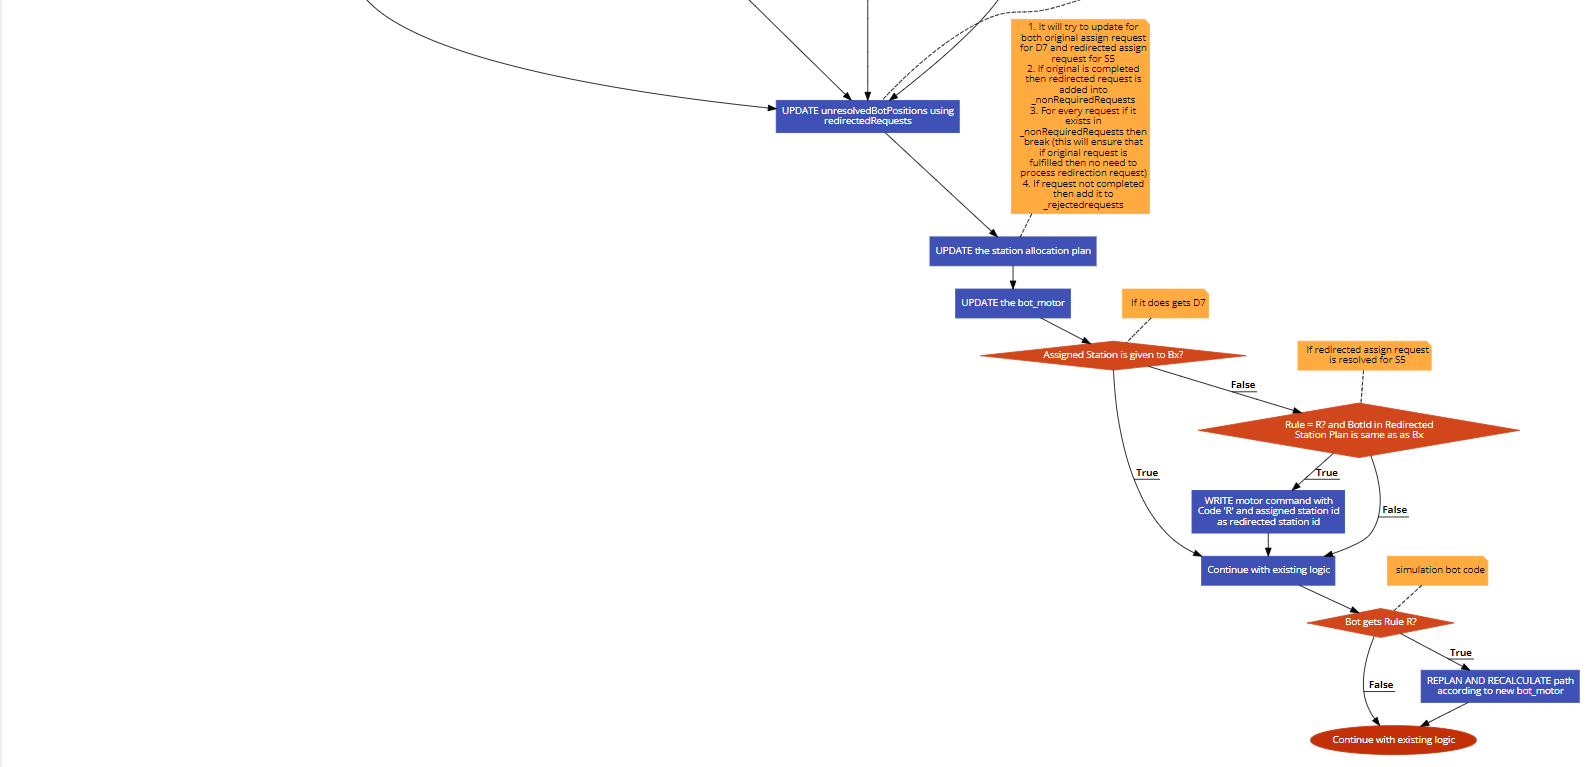

In [ ]:
https://drive.google.com/file/d/14p4jKLDoot7XHo-rqrUnkS3JhMdtPRYi/view?usp=share_link

## Redirection Logic

In [ ]:
//from station-to-station-virtual-path.json file
//Path: (X, S5, V12, V1, D7)
GET station to station virtual
path from occupied to assigned
stations;
//It will come out to be V12 and remember V1
FIND the virtual junction int he path;
//station-json-model.json file
//forward Nodes = ["V1", "V13"] for station : "V12"
// It will come out to be V13
GET the forward Node of V12 which
is not V1;
//Path: (V13, S5....., D7)
GET station to station virtual
path from V13 to D7;
//Path: (S5,...., D7)
REMOVE virtual nodes from path;
// First element of path
CREATE new assign station request for S5;

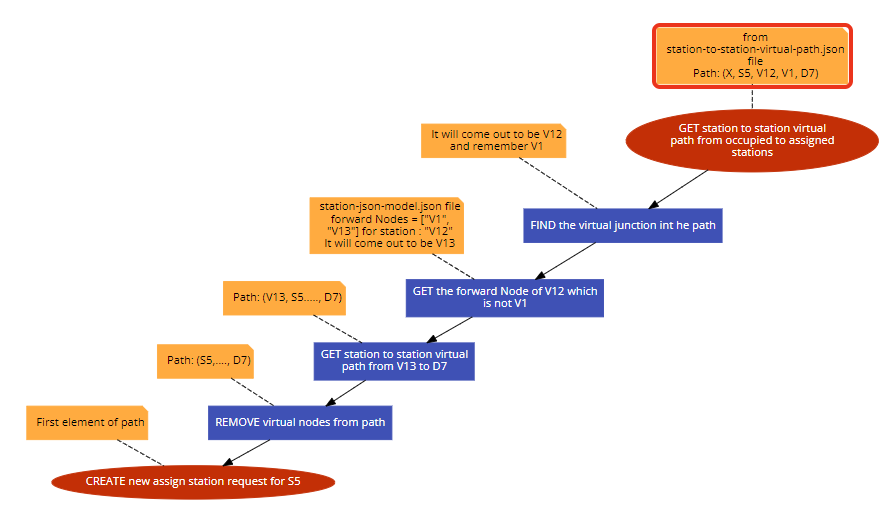

#TrafficManagementController

##StartTrafficManagement

In [ ]:
// When bots (1 or more) are initialised with certain configuration (botId, initialStationId, etc.)
Start traffic Management;
// Traffic management toggle is a variable that tells if traffic management is running or not.
Initialise all the services
SET Traffic Management Toggle = TRUE;

while(Traffic Management Toggle is TRUE?)
{
  // Logs are saved in time-logs.txt
  LOG : Start Reading Bot Position;
  // (all bot position info. of bots whhich are trying to move or unstable)
  UPDATE unresolved bot positions;
  
  // (all the status info. of all stations)
  GET all station information;
  
  // (which bot is trying to request for which station what type of request)
  UPDATE bot station requests;
  // (how stations are allocated in respect to requesting bots for move)
  UPDATE station allocation plan;
  
  // (trigger motor action/command of all the bots)
  UPDATE motor status;
  

  LOG : Updated Motor Status;
  
  WRITE bot position in logs;
  
  LOG : Going for Sleep;
}
// (graph is actually an excel file which contains botIds and coordinates)
PLOT the traffic graph;
STOP
Return "Traffic Management Started";

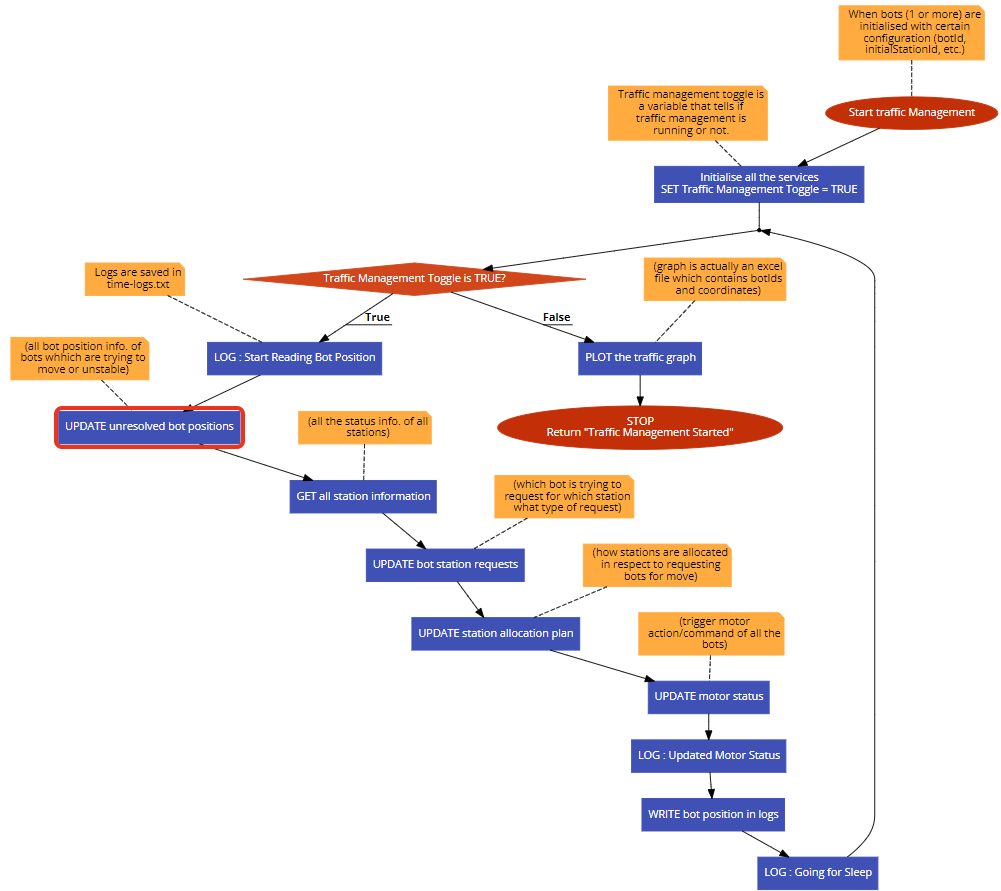

##StopTrafficManagement

In [ ]:
Stop Traffic Management;
SET Traffic Management Toggle = False;
Return True
"Traffic Management stopped";

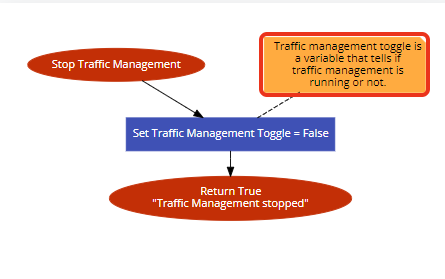

#Initialisation of Services

##BotPositionmanagementService

In [ ]:
//Initialising Services
BotPositionManagementService;
REMOVE existing bot-coordinate file;
REMOVE existing bot_position.json file;
SET botLogPositionId = 0;

// _botPositions is a dict. { botId : BotPosition } holding unresolved bot position details of all bots
CLEAR _botPositions;
//Call for next service
BotStationRequestService;

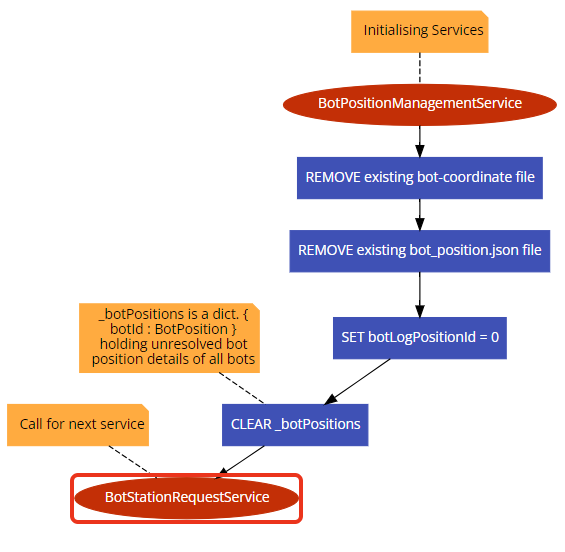

##BotStationRequestService

In [ ]:
BotStationRequestService;

// botStationRequests is a list of BotStationRequest model
CLEAR botStationRequests object;


StationAllocationService;

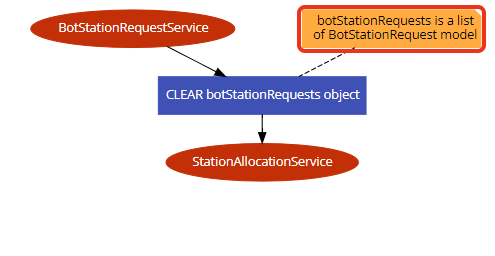

##StationAllocationService

In [ ]:
StationAllocationService;

// _stationAllocationPlan is a dict. { stationId : StationTrafficModel } which tells if station available or not and if not then tells which bot is the station
CLEAR _stationAllocationPlan;
// station information is fetched from Graph attribute StationJsonModels which is made from station-json-models.json file
INITIALISE stations, ADD ( stationId : new STM )
INTO _stationAllocationPlan;
//Call for next service
MotorControlService;

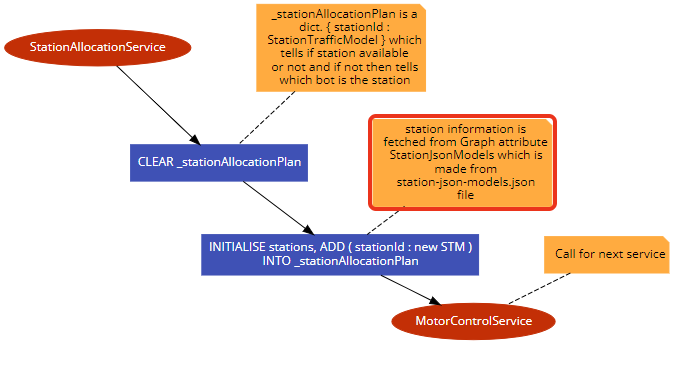

##MotorControlService

In [ ]:
MotorControlService;

// delete existing bot_motor.json file (any status information about the motor of a bot)
DELETE motorStatusLogs;
//Call for next service
SimulatorService;

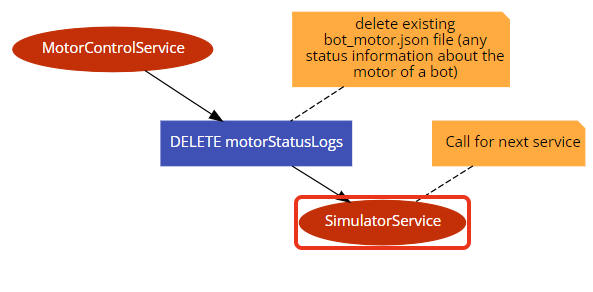

##SimulatorService

In [ ]:
SimulatorService;

// botPositions is a list of BotPosition  which gives the positional info. of bots
CLEAR _botPositions;
// _botCoordinates is a list of BotCoordinate which gives the spatial coordinate info. of bots
CLEAR _botCoordinates;
SET iterationId = 0;
//Actual logic of StartTrafficManagement
START while loop;

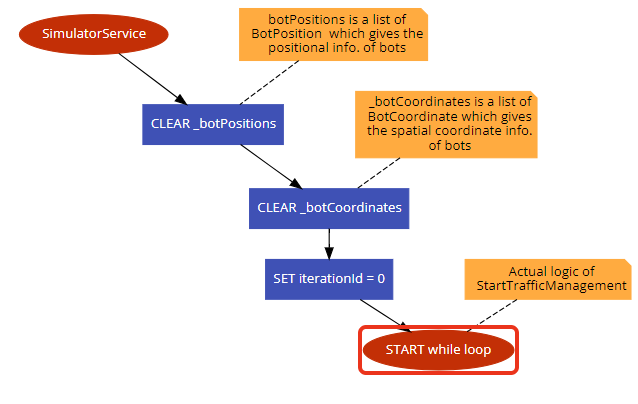

#StartTrafficManagementDetailed

In [ ]:
// When bots (1 or more) are initialised with certain configuration (botId, initialStationId, etc.)
Start traffic Management;
// Traffic management toggle is a variable that tells if traffic management is running or not.
SET Traffic Management Toggle = TRUE;
Initialise all the services (Please refer Initialisation flowcharts);

while(Traffic Management Toggle is TRUE?)
{
  // Logs are saved in time-logs.txt
  LOG : Start Reading Bot Position;
  // 1. It would include all unresolved bot positions from last iteration and current iteration unresolved bot positions mentioned in file bot_position.json and this will happen inside BotPositionManagementService (Refer UpdateBotPosition Function)
  //2. How unresolved bot positions are identified? (Refer Unresolved Bot Position Waterfall Flow Chart) 
  UPDATE unresolved bot positions
  (Include all bot positions whose one or
  more station requests are unresolved);
  
  // From stationAllocationPlan object in StationAllocationService
  GET last iteration station allocation plan
  (it provides info. if station is available for bot or not
  and if not available then also provides info. which
  bot is allocated to which station);
  
  // 1. By using unresolved bot positions and last iteration station allocation plan
  //2. Waterfall structure : Occupied -> Allocated -> Assigned -> Reserved
  //3. Rule : At one itertaion, one bot can make only one request
  //4. How requests are generated updated? If 'X' station is not allocated, then it would raise a request with correct request type
  //(Refer UpdateBotStationRequests Function)
  UPDATE bot station requests
  (which bot is trying to request for which 
  station and what type of request);
  // 1. By using unresolved bot position and updated bot station requests as update the station allocation plan to a new plan
  //2. Switch-case structure to handle different different requestTypes
  //(Refer UpdateStationAllocationPlan Function)
  UPDATE station allocation plan
  (what and how stations are allocated to
  bots according to request type);
  
  // By using unresolved bot position and updated/new station allocation plan, change the motor status. It means to rewrite the new bot_motor.json file which will contain botId and stations.
  UPDATE motor status
  (changes made in bot_motor.json file that tells
  what bot is allocated what stations);
  

  LOG : Updated Motor Status;
  
  // Keep updating the _botPositions in simulator service by using current iteration unresolvedBotPositions
  WRITE bot position in logs;
  

  LOG : Going for Sleep;
  
  WAIT for next iteration (7 ms);
}
// Graph is actually a csv file which contains botIds and coordinates and drawn by PlotBotCoordinates Function
PLOT the Traffic Graph;
STOP
Return "Traffic Management Started";

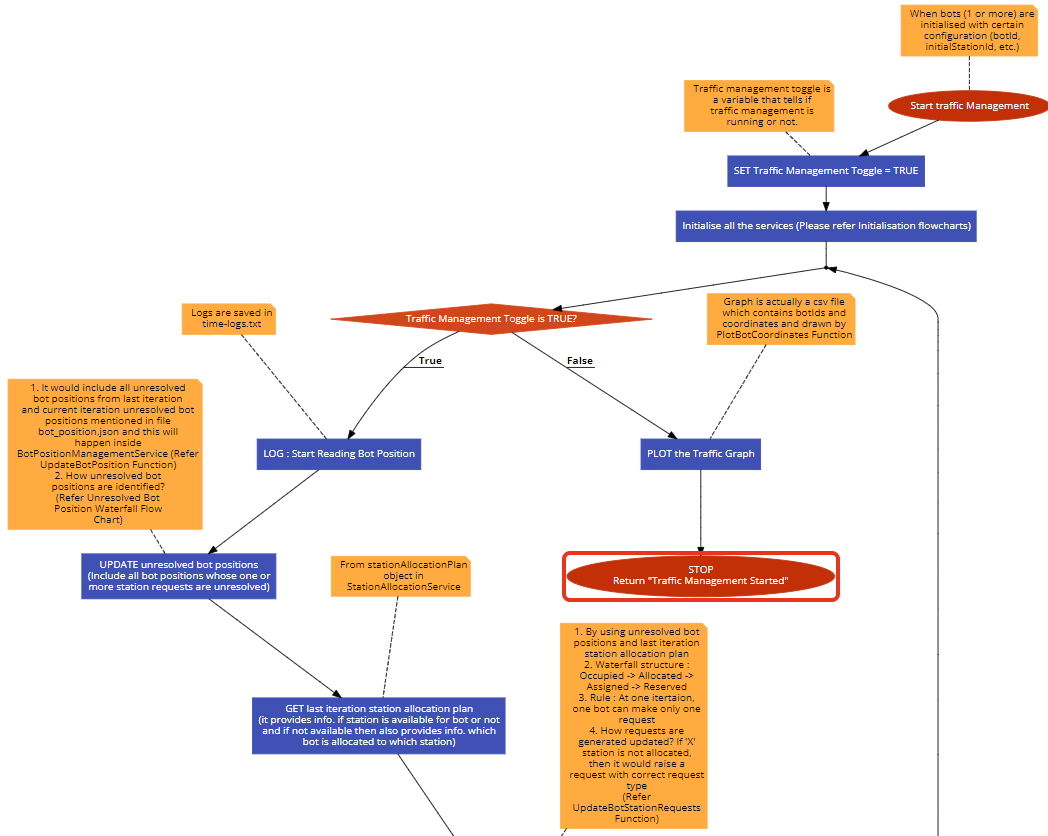

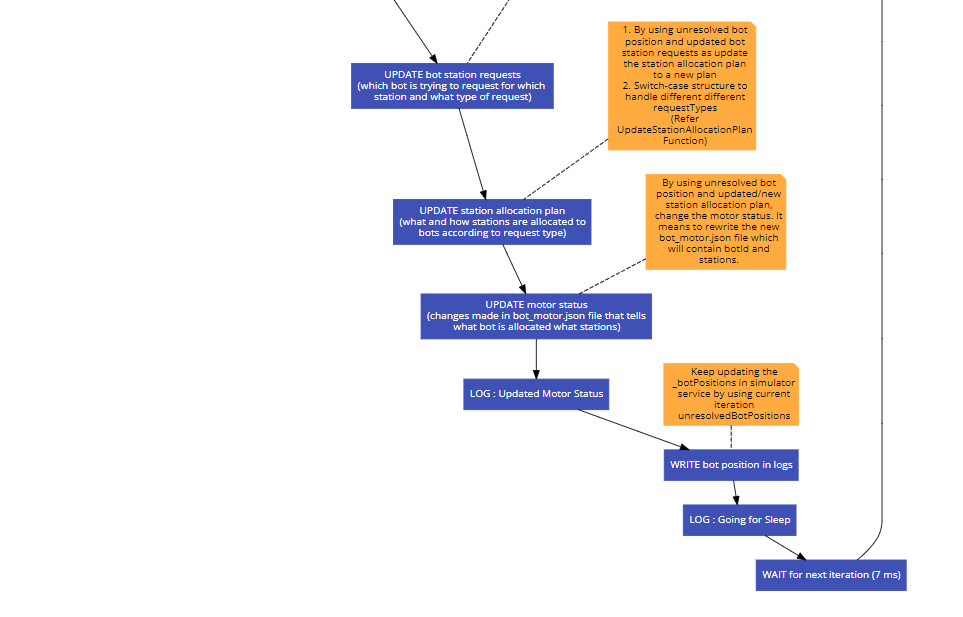

[Start Traffic Management](https://drive.google.com/file/d/1O5J0zjf0YsfsPaRXWJAmDA-Sp9pJsRcZ/view?usp=share_link)

#PathPlanningController

##ReadEdges

In [ ]:
Read Edges;

// Edge information is fetched from a file edge-json-model.json into a list of EdgeJsonModel
GET edges;
Return List of all
edges information;

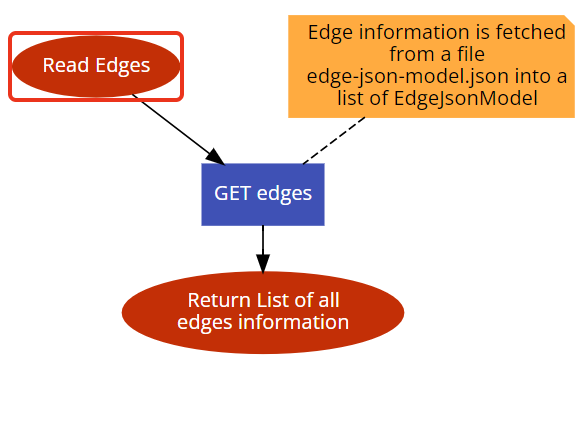

##PlotStations

In [ ]:
Plot Stations;

// Stations are created from the edges information (edge-json-model file) and station information is saved in station-json-model file.
CREATE stations;
Return List of all
stations information;

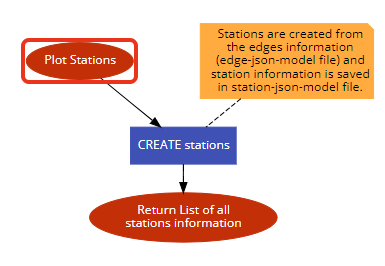

##PlotGraph

In [ ]:
Plot Graph;
Plot Graph Coordinates;
// Complex Function
GET Graph;
//Already existing graph file must be removed
DELETE all csv files;

//From Graph object
for(each EdgeJsonModel in
Graph.EdgeJsonModels)
{
  UPDATE logs in edge-coordinates file;
}
//From Graph object
for(each StationJsonModel in
Graph.StationJsonModels)
{
  UPDATE logs in node-coordinate file;
}
//Two new .csv files are created (nodes and edges)
return "Coordinates successfully plotted.
Check in log files.";

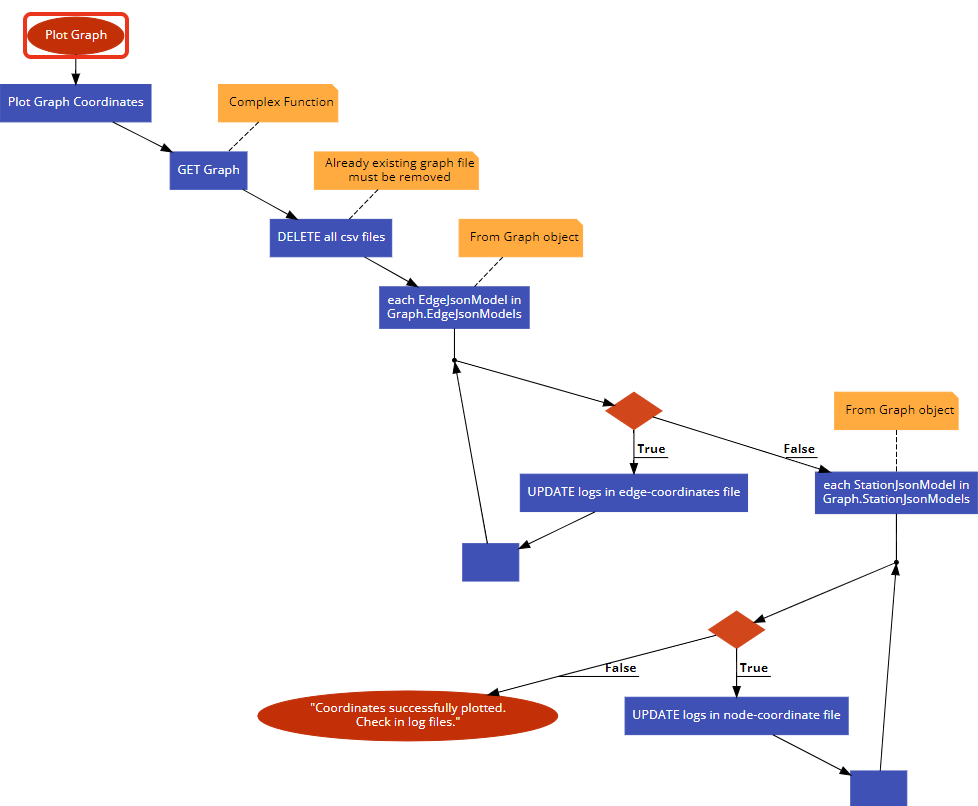

##PlotStationToStationPath

In [ ]:
Plot Station To Station Path;
//list of PathSummaryModel having every real station to real station combination shortest paths
CREATE shortestPaths;
for(each path in shortestPaths)
{
  REMOVE virtual-stations from
  path.PlannedPath;
  REVERSE path.PlannedPath;
}

for(each route in shortestPaths)
{
  // distance is being calculated using route.FromStation and route.ToStation
  ASSIGN route.Distance;
}

DELETE existing station-to-station-path file;
// using shortestPaths
CREATE new station-to-station-path file;

return shortestPaths

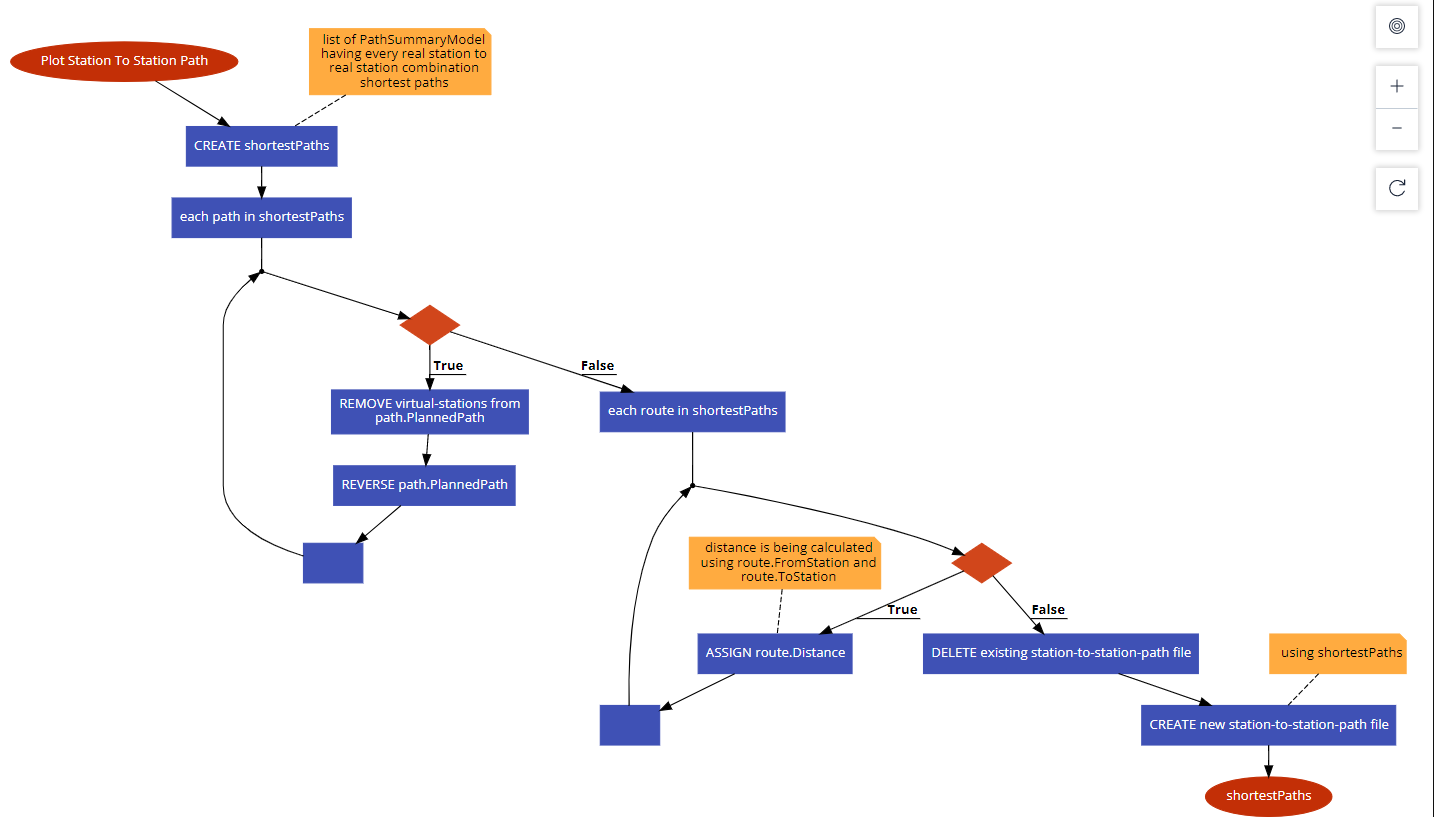

##PlotInfeedToInfeedJourney

In [ ]:
Plot Infeed To Infeed Journey;
// list of all infeed stations
GET infeedStations;
// list of all drop off stations
GET dropOffStations; 
for(each infeed in infeedStations)
{
  for(each dropOff in dropOffStations)
  {
    // infeed -> dropOff -> exit -> infeed
    ADD shortestVirtualPath in plannedPath;
    ADD closestExitPath for dropOff in plannedPath;
    ADD closestInfeedPath for last
    station in plannedPath;
    ADD directions for plannePath
    in pathDirections;
    REMOVE virtual stations from plannedPath;
    REVERSE plannedPath and pathDirections;
    //{ From = infeed.SId; To = dropOff.Si=Id; PlannedPath = plannedpath; Directions = pathdirections }
    ADD PathSummaryModel to path object;
  }
}
DELETE existing infeed-to-infeed-path file;
CREATE new infeed-to-infeed-path
file from path object;
return path;

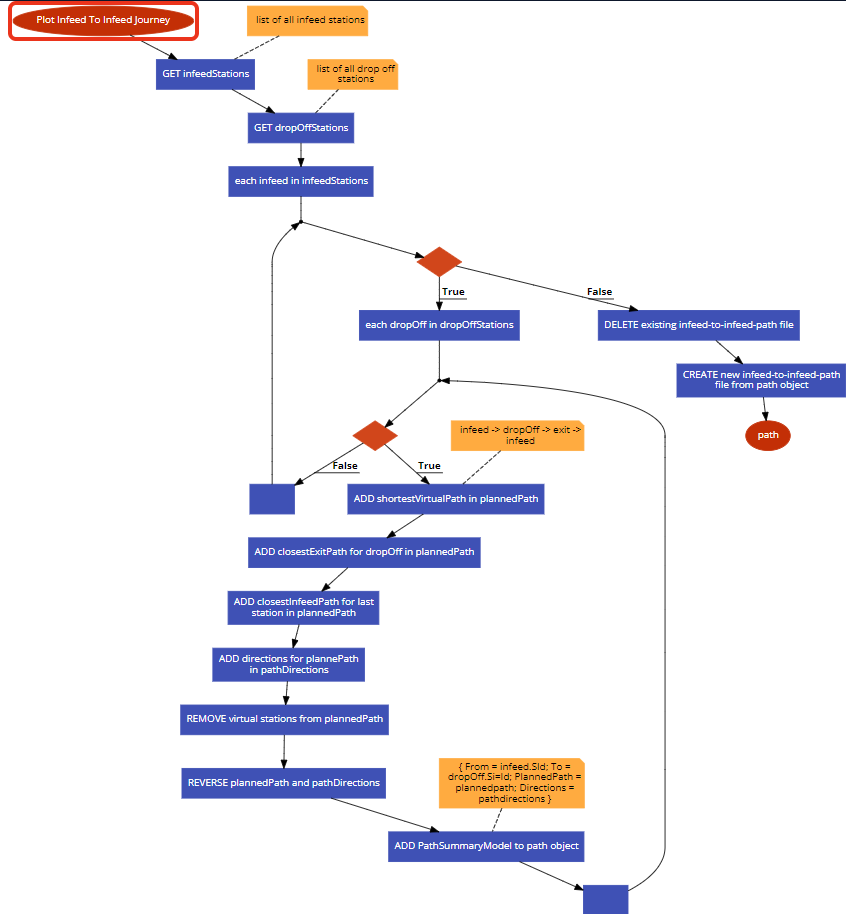

##PlottingPosition

In [ ]:
// Takes nodeId, fromSId, toSId as input
Position Plotting
( GET CoordinateOfNode );

GET virtualNode for a realNode;
GET Graph;
// using FromSId of virtualNode
GET currentStation;
// requiredEdge = virtualNode.EdgeId
GET requiredEdge;
if(requiredEdge == null)
{
  return null
}
if(requiredEdge.Type == "L")
{
  // move functions implemented in MoveAlongLineStaticService
  MOVE forward on line or edge
  and store result in nodeCoordinate;
  return nodeCoordinate;
}
if(requiredEdge.Type == "C" && clockwise == True)
{
  MOVE forward on curve clockwise
  and store result in nodeCoordinate;
  return nodeCoordinate;
}
MOVE forward on curve anticlockwise
and store result in nodeCoordinate;
return nodeCoordinate;

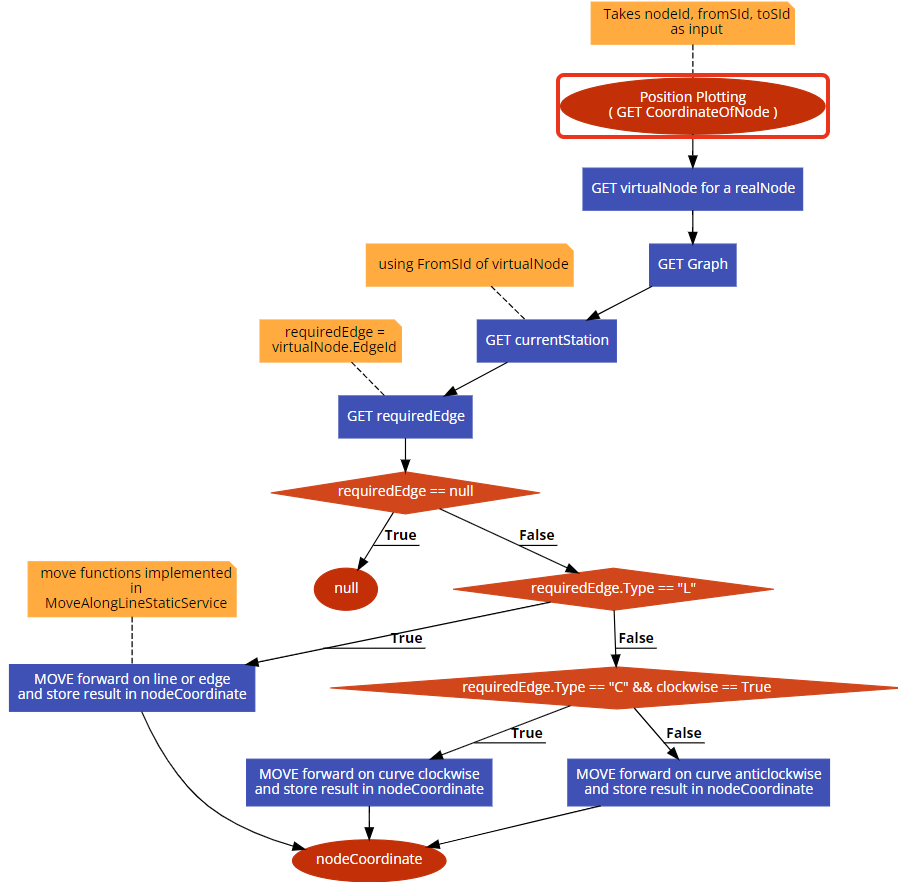

#Functions

##UpdateBotPosition

In [ ]:
// Taking dict. {botId : BotPosition} unresolvedBotPositions as an input and giving dict. {botId : BotPosition} as an output
UpdateBotPositions;

// _botPositions is a dict. {botId : BotPosition}
CLEAR _botPositions object;

ADD unresolvedBotPositions
INTO _botPositions;

// this will be read from file bot_position.json
GET botPositions;

if(botPositions == null)
{
  Return _botPositions;
}

for(each botPosition in botPositions)
{
  if (botPosition NOT PRESENT
  in _botPositions)
  {
    // adding previous unresolvedbotPositions
    ADD botPosition
    in _botPositions;
  }
}

INCREMENT botLogPositionId by 1;

Return clone of _botposition

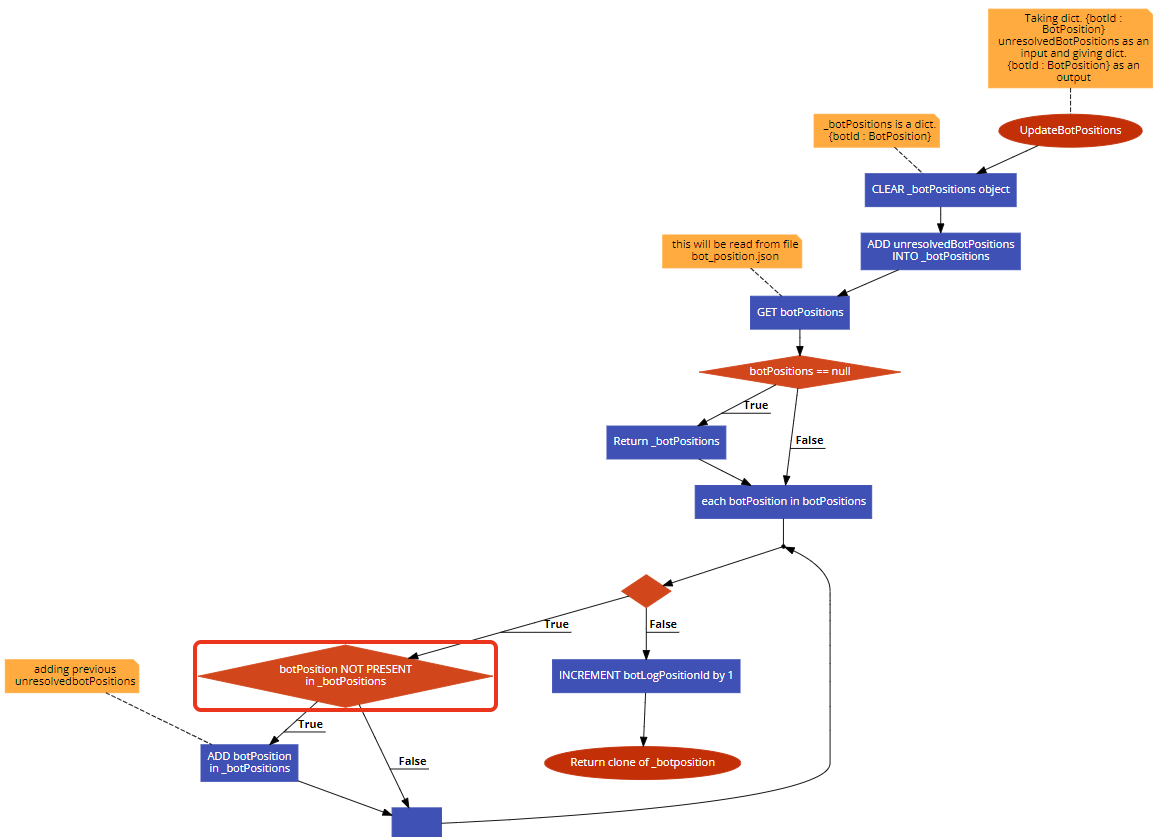

##UpdateBotStationRequest

In [ ]:
// Taking unresolvedBotPosition dict. {botId : BotPosition} and stations dict. {stationId : StationTrafficModel) as input and list of BotStationRequest as output
UPDATE BOT STATION REQUEST;

// list of BotStationRequest {botId, stationId, requestType}
// all requests will be added here
CLEAR _botStationRequests;

for(each botPosition in unresolvedBotPositions)
{
  // [Check] Current Station Id exists
  if(allocatedStationId and occupiedStationId of
  botPosition NOT EXIST in status allocation plan
  (stations))
  {
    // INVALID : poses a logical question that if the station don't exist in plan then how bot is allocated that station
    ADD Station Request of type INVALID;
    continue;
  }
  
  // Case: Occupied Station is not updated
  if(occupiedStation of botPosition exists in
  stations but botId mentioned in oS is NOT EQUAL
  to the KEY(botId) of botPosition)
  {
    ADD Station Request of type UNAUTHORISED;
    continue;
  }
  
  // Case: Occupied Station status is not updated
  if(occupiedStation of botPosition exists in
  stations but requestType mentioned in oS is NOT
  'OCCUPIED')
  {
    // OCCUPIED : that station is occupied by that bot
    ADD Station Request of type OCCUPIED;
    continue;
  }
  
  // Case: Allocated Station  is not updated or Status is not updated
  if(allocatedStation of botPosition exists in
  stations but either botId mentioned in allS is
  NOT EQUAL to the KEY(botId) of botPosition or
  requestType mentioned in allS is NOT
  'ALLOCATED')
  {
    // ALLOCATE : the station on which bot will arrive next just after occupied
    ADD Station Request of type ALLOCATE;
    continue;
  }
  
  // Case: Assigned Station and Reserved station is not provided we fetch it using ForwardNodes of allocated station
  if(assignedStation NOT EXIST in stations)
  {
    // that particular station whose stationId is EQUAL to the allocatedStationId in botPosition
    GET StationJsonModel from Graph;
    //ForwardNodes contain the next nodes which will come after that station
    ASSIGN assignedStationId of botPosition to
    first element of ForwardNodes in StationJsonModel;
    if(there are more than 1 ForwardNodes)
    {
      ASSIGN reservedStationId of botPosition to
    second element of ForwardNodes in StationJsonModel;
    }
  }
  
  // Case: Assigned Station  is not updated or Status is not updated
  if(assignedStation of botPosition exists in
  stations but either botId mentioned in assgS is
  NOT EQUAL to the KEY(botId) of botPosition or
  requestType mentioned in assgS is NOT
  'ASSIGNED')
  {
    // ASSIGN : the station on which bot will arrive after passing allocated station
    ADD Station Request of type ASSIGN;
    continue;
  }
  
  // Case: Reserved Station  is not updated or Status is not updated (only here we will also check first that reserved station must exist to make the request)
  if(reservedStation of botPosition EXISTS in
  stations and either botId mentioned in resS is
  NOT EQUAL to the KEY(botId) of botPosition or
  requestType mentioned in resS is NOT
  'RESERVED')
  {
    // RESERVE : the station on which bot will further arrive after passing the assigned station
    ADD Station Request of type RESERVED;
    continue;
  }
  
}

Return _botStationRequests;

[UpdateBotStationRequestWaterFall](https://drive.google.com/file/d/1rPsY_T5TZsx0rYSUPgNpZ1CAxuqwN0dh/view?usp=share_link)

##UpdateStationAllocationPlan

In [ ]:
// takes the list of botStationRequests and dict. { botId : Botposition } unresolvedBotPositions as input and gives dict. { stationId : StationTrafficModel } as output
UPDATE STATION ALLOCATION PLAN;
for(each botStationRequest in botStationRequests)
{
  switch(RequestType)
  {
    case OCCUPIED:
    {
      // changes made in _stationAllocationPlan for particular request
      //(Refer Internal UpdateStationAllocationPlan Function)
      UPDATE station allocation plan;
      break;
    }
    
    case ALLOCATE:
    {
      // station is the one whose stationId = stationId mentioned in botStationRequest
      if(station in current stationAllocationPlan is
      AVAILABLE OR botId mentioned in station is EQUAL
      to botId mentioned in botStationRequest)
      {
        UPDATE station allocation plan;
      }
      break;
    }
    
    case RESERVE:
    {
      if(station in current stationAllocationPlan is
      AVAILABLE OR botId mentioned in station is EQUAL
      to botId mentioned in botStationRequest)
      {
        UPDATE station allocation plan;
      }
      break;
    }
    
    case ASSIGN:
    {
      if(station in current stationAllocationPlan is
      AVAILABLE OR botId mentioned in station is EQUAL
      to botId mentioned in botStationRequest)
      {
        UPDATE station allocation plan;
      }
      break;
    }
    
    case INVALID:
    {
      break;
    }
    
    case UNAUTHORISED:
    {
      //Refer PriorityBotForStation Function
      if(station can be made available for the bot)
      {
        CHANGE the requestType of botStationRequest
        to ALLOCATE;
        UPDATE station allocation plan;
      }
      break;
    }
  }
}
Return _stationAllocationPlan;

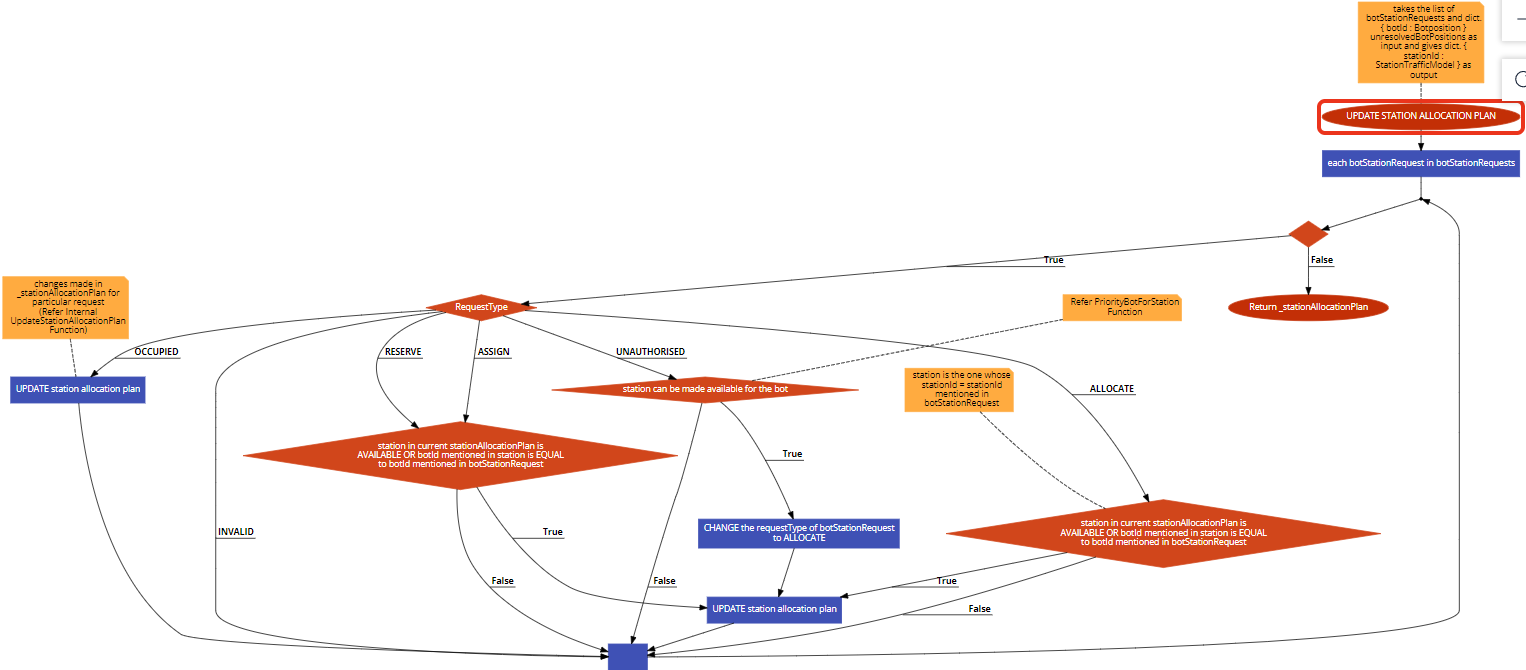

##Internal UpdateStationAllocationPlan

In [ ]:
//takes stationRequest as an input and update allocation plan as an output
UpdateStationAllocationPlan;
//Check if any other station Id is not allocated to bot
// prev. station is the one whose botId and requestType are same as that of input request
GET previous station;
if(prev. station NOT NULL)
{
  CHANGE allocation plan of the station as
  Available = True, BotId = null and RequestType
   = Default;
}
CHANGE allocation plan of the station as
  Available = False, BotId = BotId in request
  and RequestType = RequestType in request;
Updation Complete;


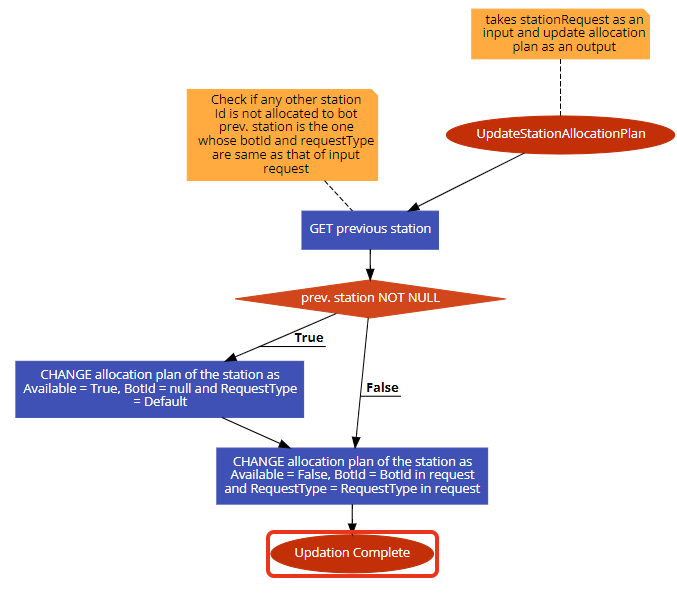

##PrioritizeBotForStation

In [ ]:
// The function is used to make station available for the bot with unauthorised request
PrioritizeBotForStation;
GET the station from station allocation
plan with same stationId as mentioned in
stationRequest;
// [case] Station is not allocated to bot but station is  available
if(station is Available)
{
  return Return True;
}

// [case] unreserve some reserved station
if(expectedBotId is NOT NULL in station)
{
  UNRESERVE the station;
  return Return True;
}
// [case] Station is not allocated to bot but station is  allocated  to some other bot -> Check which bot is ahead,
// the one which is ahead will be allowed to go first in order to avoid collision
if(botId is NOT NULL in station)
{
  GET the current botPosition using botId
  in station;
  GET the botPosition of unauthorised bot;
  
  if(nodeId of curr. bot < nodeId of unauthorised bot)
  {
    UNALLOCATE the occupied station
    of curr. bot;
    UNRESERVE the allocated station
    of curr. bot;
    return Return True;
  }
  
  return Return False;
}

return Return False;

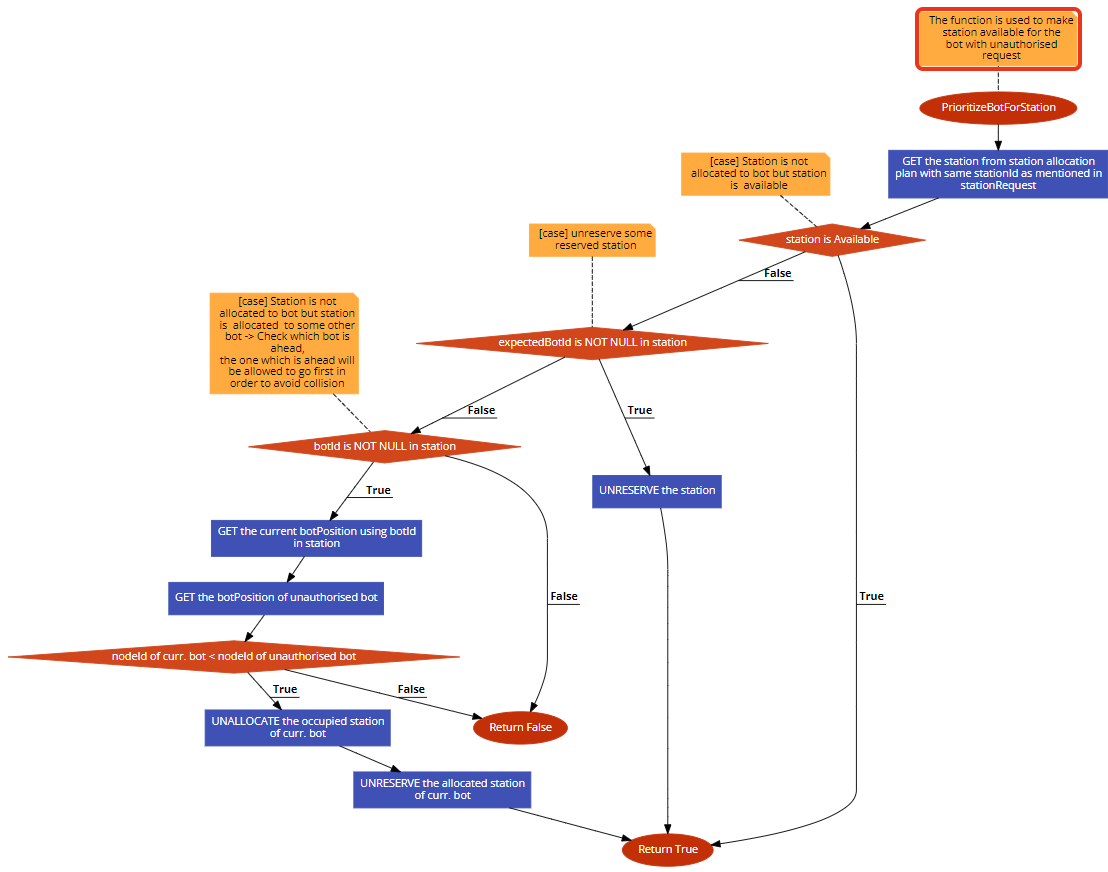

#Simulation

##Bot Manifestation (get_next_station.py)

In [ ]:
LOG : INFO in datacamp.log;
// it makes a connection with messaging server (Refer Messaging-Server Flow Chart)
CONNECT with local IP;

//INITIALISATION
INITIALISE variables and Traffic params;
// eg. Bot_Id, Occupied_Station_Id, Initial_Station, ... etc.
INITIALISE Bot params;

UPDATE parcel dropped info.
to clear any past residue;
// path from starting station to closest infeed station
//Planned_Path is an array containing different stationIds
GET Planned_Path of bot;

ASSIGN Infeed_Station and Occupied_Station_Id;
params of Bot as first and last element of Planned_Path;
//if there are many stations between starting station and nearest infeed station
if(length of Planned_Path > 1)
{
  // Allocated = next station, assigned = next to next, reserved = next to next to next
  //Distance_For_Next_Station is always between occupied and allocated stations
  ASSIGN Allocated_Station_Id = second last element
  of Planned_Path and Distance_For_Next_Station = distance
  between occupied and allocated stations;
}

// bot starts to function actually (INITIALISATION is complete)
while(True)
{
  CALCULATE Speed of Bot using prev. Speed;
  CALCULATE Path_Travelled by Bot based on Speed;
  GET Node_Id of Bot;
  // means bot will cross the station)
  if(Path_Travelled > Distance_For_Next_Station)
  {
    Step 1: RECALCULATE Path_Travelled by subtracting distance
    for next station from prev. path travelled
    Step 2: GET new Node_Id;
    // since it has covered this station
    DELETE station from Planned_Path inplace;
    //occupied station will always be the last element of Planned_Path array
    REASSIGN Occupied_Station_Id of Bot;
    // bot has reached the infeed station
    if(length of Planned_Path == 1)
    {
      SET Motor of bot to 0;
      continue;
    }
    // allocated station will always be the second last element of Planned_Path array
    // occupied and allocated station Ids are always a must for bot operation
    REASSIGN Allocated_Station_Id;
    //Check the length of Planned_Path before assigning to Assigned_Station_Id and Reserved_S_Id. If that much stations available, then assign both of them
    //assigned station will always be the third last element of Planned_Path array
    // reserved station will always be the forth last element of Planned_Path array
    Step 1: REASSIGN Assigned_Station_Id, Reserved_Station_Id
    and Distance_For_Next_Station of Bot
    Step 2: PRINT Bot Info.;
  }
  // if reached at infeed station
  if(Occupied_Station_Id == Infeed_Station and length
    of Planned_Path == 1)
    {
      GET Dropping_Station which is next dropping assg.;
      //somehow not able to get next dropping assignment then try again
      if(Dropping_Station == null)
      {
        continue;
      }
      // infeed station to dropping station
      // not able to get planned_path then try again
      UPDATE Planned_Path;
      if(Planned_Path is None)
      {
        continue;
      }
      
      Step 1: REASSIGN Infeed_Station, Allocated_Station_Id,
      Assigned_Station_Id, Reserved_Station_Id and Distance_For_Next_Station
      Step 2: CLEAR infeed station;
    }
    
    if(Occupied_Station_Id == DroppingStation)
    {
      UPDATE parcel dropped info. and INCREMENT
      the no. of dropped parcels by 1;
    }
    
    UPDATE Motor by getting motor-status
    from server;
    
    INCREMENT Response_Id by 1;
    
    SLEEP for 100ms;
}

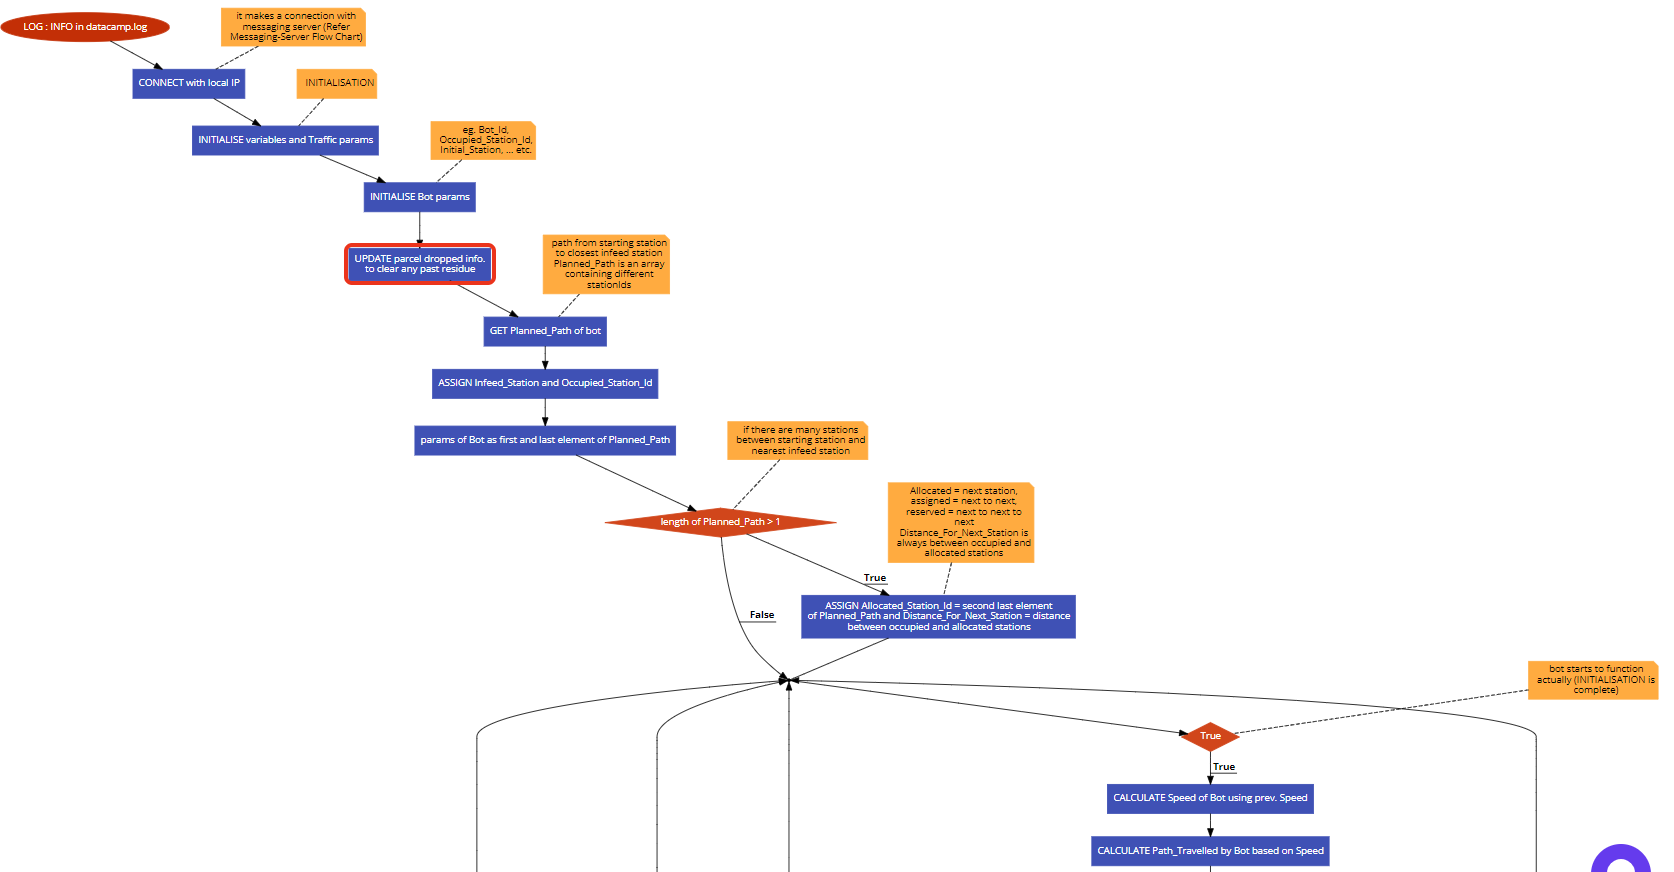

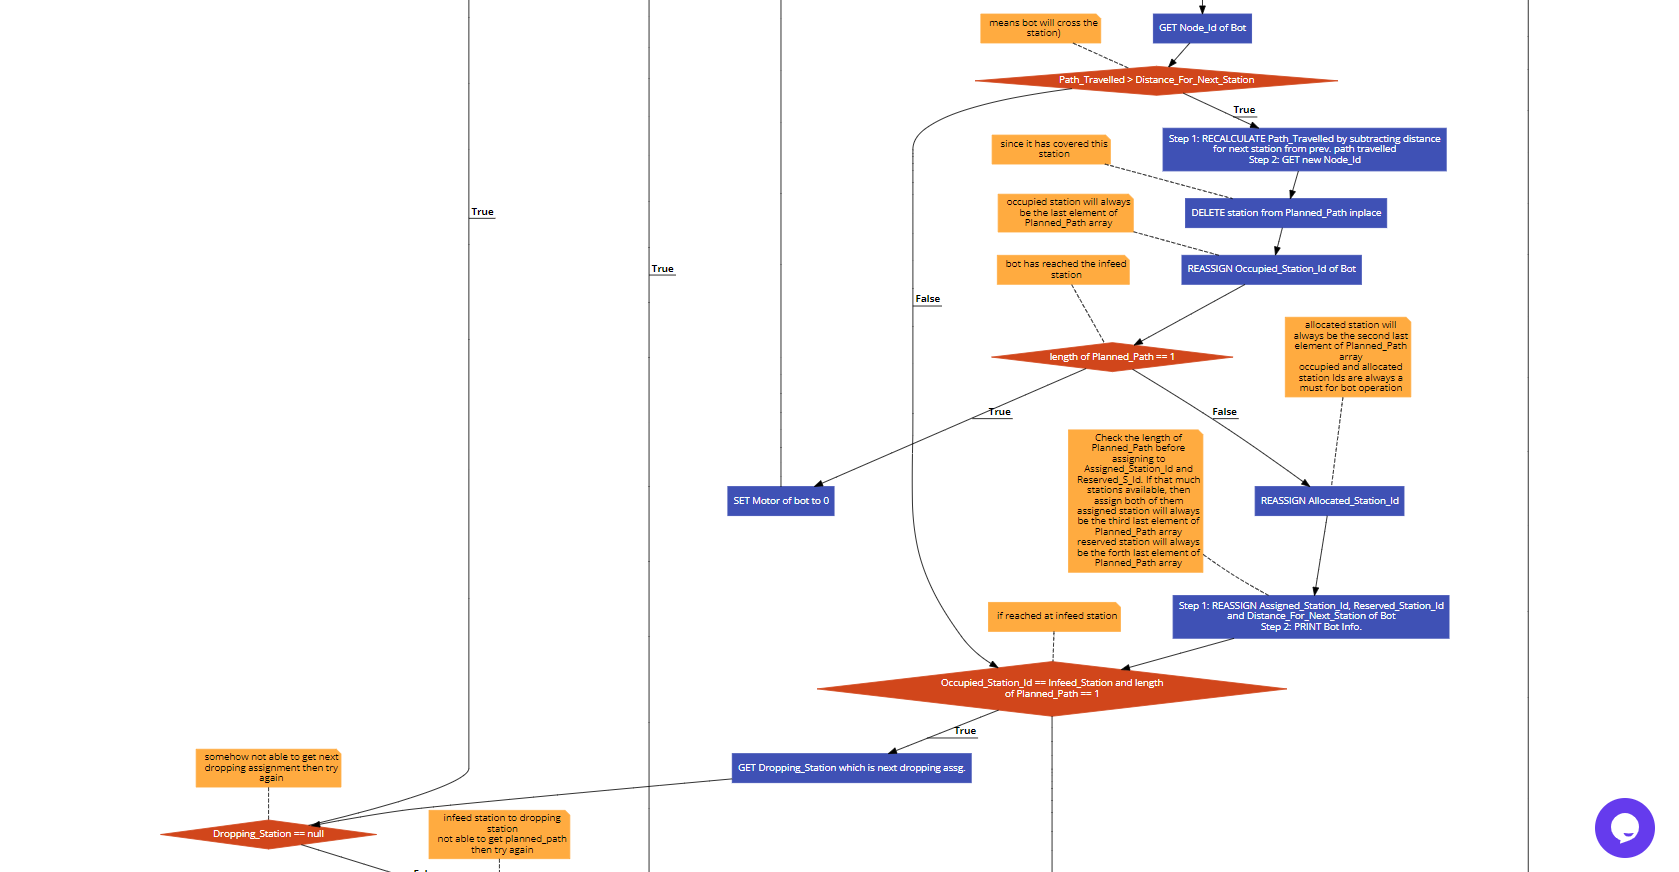

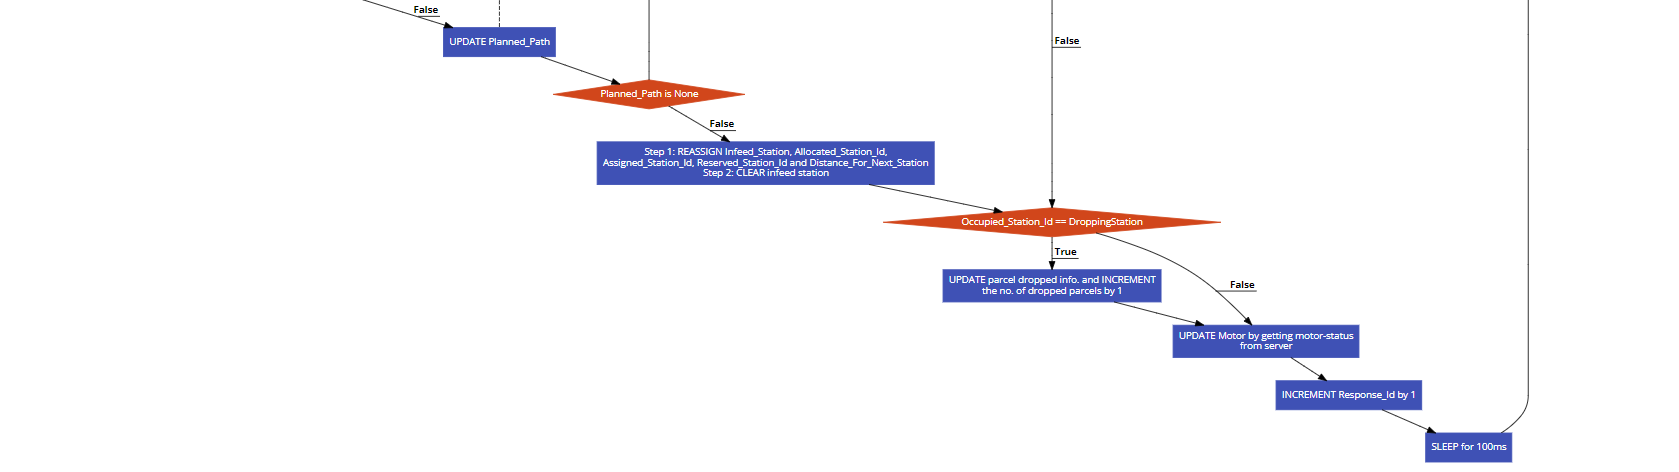

[Bot_Manifestation](https://drive.google.com/file/d/1nrF814PN5a6-cQTNuqPS-t1MnvWrSOlX/view?usp=share_link)

##Messaging Server (main_9999.py)

In [ ]:
CONNECT to local IP;
// bot_manger is a class with extension functions
INSTANTIATE bot_manger.py;
// Bots will hold botPosition info of bots and Bot_Motors holds the information about botMotors
INITIALISE Bots and Bot_Motors;
while(True)
{
  DELETE bot_position.json file;
  if(delete successful?)
  {
    break;
  }
}
// bot_position file is created/updated by this msg server
//(Refer update_bot_position flow chart)
CREATE Thread 1 for task update_bots_position;

START Thread 1;
//notify about start of server
NOTIFY on desktop;

// handles (UDP) datagram based http request
//(Refer msg server handler flow chart)
KEEP RUNNING the server to handle request;

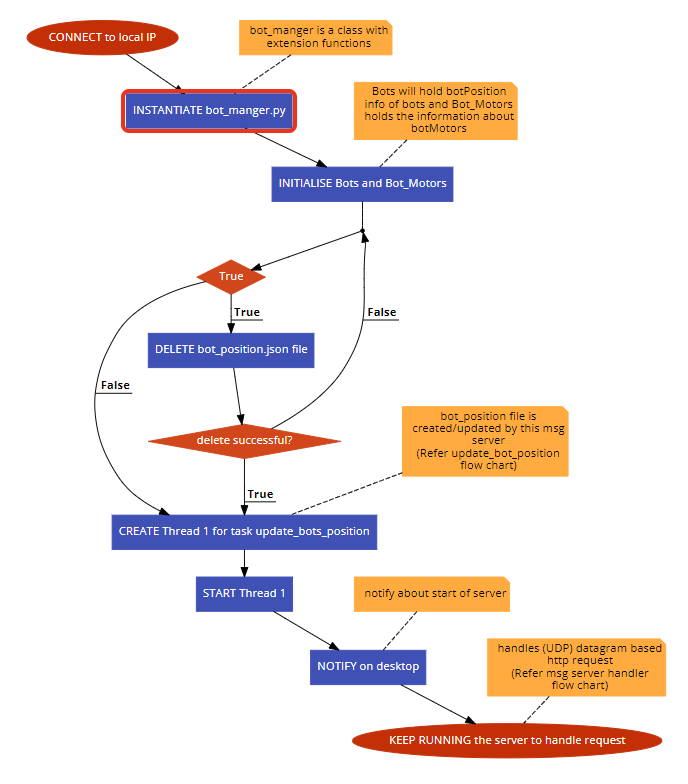

##update_bots_position

In [ ]:
update_bots_position;
// these are the time elapsed in millisecond from epoch
INITIALISE timer and timer_1;
while(True)
{
  try
  {
    if(delay with respect to timer_1 > 10ms)
    {
      UPDATE timer_1;
      // read from bot_motor.json file and fetched as numpy array of json objects
      GET current motor logs;
      if(current motor logs EXIST)
      {
        // Bot_Motors holds the data of bot_motor.json file
        Bot_Motors = current motor logs;
      }
      
    }
    // checked by len(Bots) == 0
    if(there are NO bots)
    {
      continue;
    }
    
    if(delay with respect to timer > 3ms)
    {
      UPDATE timer;
      PRINT : Updating Bot Position;
      // updation takes places by replacing previous bot_position.json file with Bots
      UPDATE bot_position.json file;
      if(updation is successful)
      {
        //Bots hold the data of bot_position.json file
        CLEAR Bots;
        PRINT : Updated Bot Positions;
      }
    }
  }
  
  catch (exception e)
  {
    PRINT e;
  }
  
}

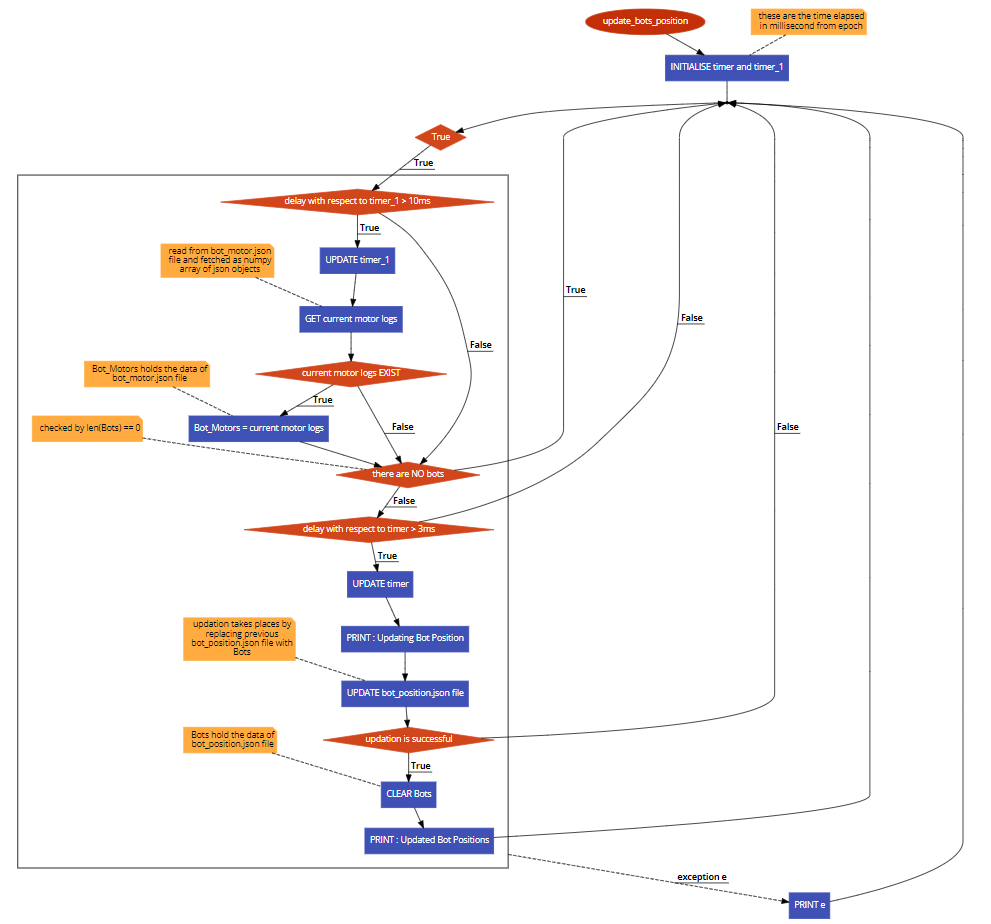

##msg server handler

In [ ]:
MyUDPHandler;
//inside handle function
RECIEVE Request from Bot;
LOG : Data of Request;

// handle function complete
UPDATE bot by update_bot_position
using decoded Request data;
// if there have been some sort of bot updation
if (updated_bot NOT 0)
{
  APPEND updated_bot in Bots;
  GET bot_motor for the updated_bot;
  // if motor info for that bot exists
  if(bot_motor NOT 0)
  {
    PRINT : Bot details and Bot Motor details;
    SEND bot_motor of updated_bot and updated_bot
    info. to the bot;
  }
  else
  {
    PRINT : Bot details;
    SEND updated_bot info. to the bot;
  }
}

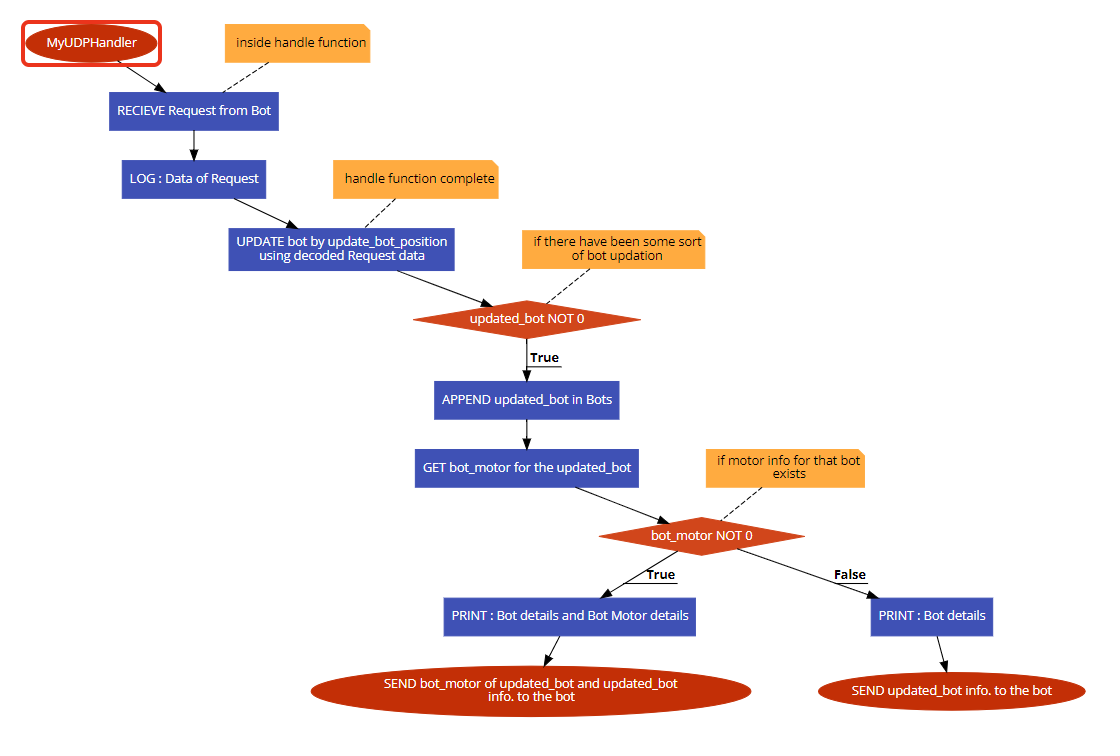

#Unresolved Bot Position Waterfall

In [ ]:
//Inside UpdateMotorStatus in MotorControlService that takes dict. unresolvedBotPositions { botId : BotPosition } and dict. stations { stationId : StationTrafficModel } as input and gives dict. { botId : BotMotor } as output
UpdateMotorStatus;
// _unresolvedBotPositions is a dict. { botId : BotPosition }
CLEAR _unresolvedBotPositions;

for(each botPosition in unresolvedBotPositions)
{
  // waterfall conditions for being unresolved bots
  //(A bot is unresolved if all 4 type of stations occupied, allocated, assigned and reserved are NOT available for a bot)
  try
  {
    if(occupiedStation NOT PRESENT in stations
    or though station PRESENT but botId mentioned
    in that particular station does NOT EQUAL to
    KEY(botId) of botPosition)
    {
      continue;
    }
    
    if(allocatedStation NOT PRESENT in stations
    or though station PRESENT but botId mentioned
    in that particular station does NOT EQUAL to
    KEY(botId) of botPosition)
    {
      continue;
    }
    
    if(assignedStation NOT PRESENT in stations
    or though station PRESENT but botId mentioned
    in that particular station does NOT EQUAL to
    KEY(botId) of botPosition)
    {
      continue;
    }
    
    if(reservedStation NOT PRESENT in stations
    or though station PRESENT but botId mentioned
    in that particular station does NOT EQUAL to
    KEY(botId) of botPosition)
    {
      continue;
    }
  }
  
  catch(Exception e)
  {
    WRITE e;
    continue;
  }
  // This function actually updates the _motorStatus based on botPosition and a flag about bot is resolved or not. Here TRUE is passed
  WRITE Motor Command;
  // Bot is said to be reolved when all 4 type of stations occupied allocated, assigned and reserved are allocated to the bot
  ADD botPosition KEY(botId) to resolvedBotIds;
}
UPDATE motor log;
ADD all the unresolvedBotPositions to
_unresolvedBotPositions;
//this _unresolvedBotPositions object is returned as output for all function calls of other services asking to get unreolvedBotPositions
REMOVE each botId in resolvedBotIds
from _unresolvedBotPositions;
//_motorStatus is an internal MotorControlService object which is a dict. { botId : BotMotor }
Return _motorStatus;

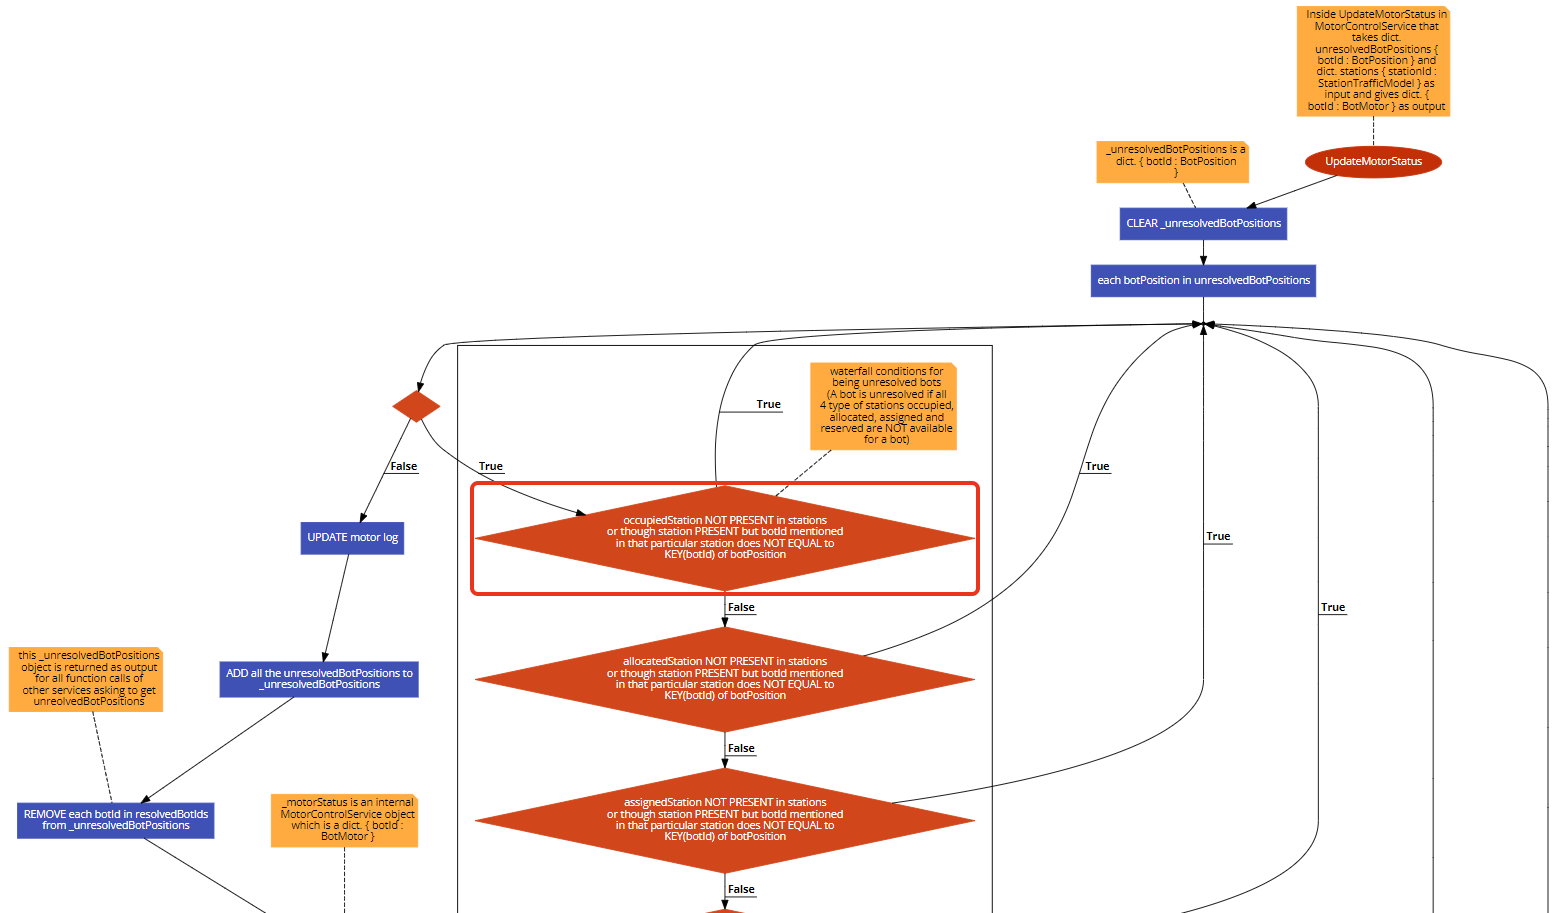

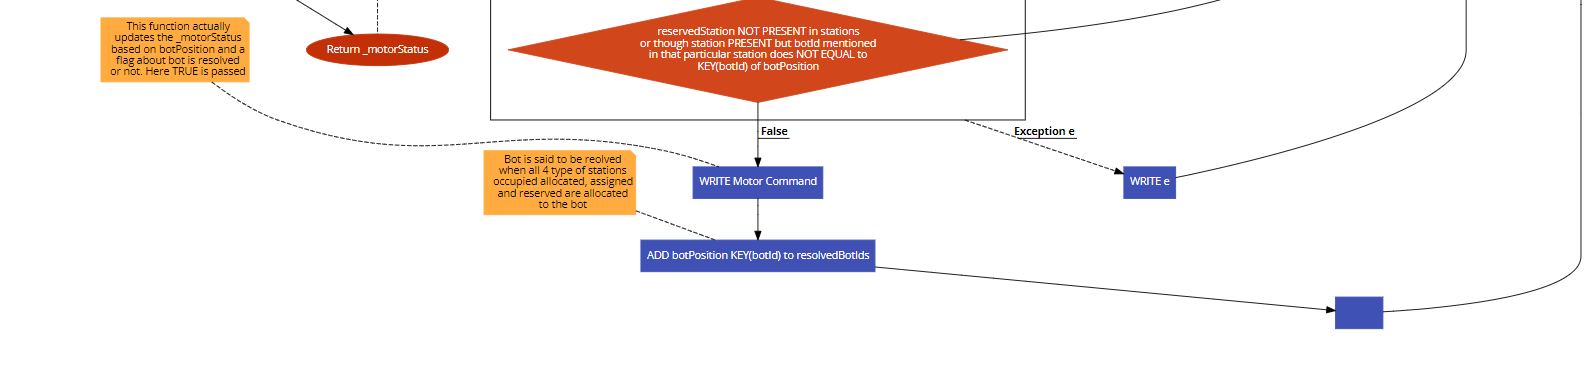